### Objective: To extract features for single mutants provided by Ishtvan. 

Ishtvan provided a data set for about 900 mutations. I am going to use dask to run through this for feature generation. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm.notebook import tqdm 
import numpy as np
import nglview as nv
from abnumber import Chain as AbChain
from Bio.PDB.PDBParser import PDBParser
from Bio.PDB.PDBIO import PDBIO
from multiprocessing import cpu_count

from dask import compute, delayed
from dask.diagnostics import ProgressBar
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from developability.utils import ls, extract_sequence_from_pdb, determine_chain_type, clean_logs
from developability.pipeline import run_processing_pipeline
from developability.pdb_tools import extract_fv_from_pdb, fix_antibody, generate_mutations_dict, mutate_protein, extract_sequence_from_pdb



pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
%config InlineBackend.figure_format='retina'

In [2]:
def calculate_number_batches(n, batch_size=100):
    """Return number of batches for a given number of samples and batch size."""
    return (n + batch_size - 1) // batch_size


def mutation_pipeline(parent_pdb, mutations, output_path, output_path_suffix='output', clean=False): 
    """ pipeline for computing developability features for a mutated protein. Mutation occurs via OpenMM/PDB fixer. 

    Args:
        parent_pdb (str|Path): Path to parent PDB file
        mutations (list[list]): mutations
        output_path (str|Path): 
        clean (bool, optional):  Whether to clean logs after processing.Defaults to False

    Returns:
        _type_: _description_
    """
    # extract sequence from pdb file
    seqs = extract_sequence_from_pdb(parent_pdb)
    light_chain_seq , heavy_chain_seq = determine_chain_type(seqs)

    seqs['L'] = light_chain_seq
    seqs['H'] = heavy_chain_seq

    light_chain_length = len(light_chain_seq)
    heavy_chain_length = len(heavy_chain_seq)

    mutations_dict = generate_mutations_dict(mutations, light_chain_length, heavy_chain_length)
    mutated_pdb = mutate_protein(parent_pdb, mutations_dict)

    name = mutated_pdb.name.split('.')[0]
    output_path = output_path/ f'{name}_{output_path_suffix}'
    return run_processing_pipeline(mutated_pdb, output_path, clean = clean)
    

def batch_process_mutations(parent_pdb, mutation_df, output_path,  batch_size=32, njobs=None): 
    """ batch process mutations. 

    Args:
        parent_pdb (str|Path): Path to parent PDB file
        mutation_df (pd.DataFrame): dataframe with mutations

    Returns:
        pd.DataFrame: dataframe with developability features for each mutation
    """
    if not output_path.exists(): 
        output_path.mkdir(parents=True)

    results = []
    n_batches = calculate_number_batches(len(mutation_df), batch_size=batch_size)
    batches = np.array_split(mutation_df, n_batches)

    
    for batch in tqdm(batches, total = n_batches): 
        futures = [delayed(mutation_pipeline)(parent_pdb, row, output_path) for _, row in batch.iterrows()]
        results.extend(compute(*futures, scheduler='processes', num_workers=njobs))
        pd.concat(results).to_parquet(output_path / 'descriptors.parquet')
        clean_logs()

    return pd.concat(results)





### Paths to data 

In [3]:
DATAPATH  = "/Users/ChristopherRivera/Documents/DataResults/MPK190" 
data_path = Path(DATAPATH)

mutations_path = data_path / 'v10-mutagenesis'


parent_pdb = mutations_path/'MPK190.fv_only.pdb'

mutations_text_file = mutations_path/'v10-mutagenesis.csv'



In [4]:
nv.show_structure_file(str(parent_pdb))

NGLWidget()

### Parse the mutations file

In [5]:
def format_mutation(mutation): 
    chain, mutation = mutation.split('|')
    return [mutation[0],int(mutation[1:-1]), mutation[-1]]


def parse_mutations_text(mutations_text_file): 
    """ parse mutations text file into a dataframe. 

    Args:
        mutations_text_file (str|Path): path to mutations text file

    Returns:
        pd.DataFrame: dataframe with mutations
    """

    data = [line for line in mutations_text_file.read_text().split('\n') if line]
    mutations= []
    hc = []
    lc = []
    for line in data: 
        if line.startswith('List'): 
            line = line.split(',')
            mutations.append(line[1])
            hc.append(line[2])
        elif line:
            lc.append(line.replace(',', ''))
    lc = lc[1:]


    mutation_df = pd.DataFrame(dict(mutation = mutations, HC = hc, LC=lc))

    mutation_df['Vh mutations'] = [[format_mutation(m)] if m[0]=='H' else [] for m in mutation_df['mutation']]
    mutation_df['Vl mutations'] = [[format_mutation(m)] if m[0]=='L' else [] for m in mutation_df['mutation']]
    return mutation_df

mutation_df = parse_mutations_text(mutations_text_file)

In [6]:
mutation_df.head()

,mutation,HC,LC,Vh mutations,Vl mutations
0,H|Q1A,AVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, A]]",[]
1,H|Q1C,CVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, C]]",[]
2,H|Q1D,DVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, D]]",[]
3,H|Q1E,EVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, E]]",[]
4,H|Q1F,FVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, F]]",[]


### Check mutations. 

In [7]:
def consensus(seqs): 
    pos = {}
    for seq in seqs:
        for i, aa in enumerate(seq):
            pos.setdefault(i+1, {})
            pos[i+1].setdefault(aa,0 )
            pos[i+1][aa] += 1
    
    return ''.join([max(pos[p], key=pos[p].get) for p in pos])   

def calculate_edit_distance(seq1, seq2):
    assert len(seq1) == len(seq2)
    return sum( 1 if aa1 !=aa2 else 0 for aa1, aa2 in zip(seq1, seq2))


def identify_mutations(parent, child): 
    mutations = []
    for i, (aa1, aa2) in enumerate(zip(parent, child)): 
        if aa1 != aa2: 
            mutations.append([aa1, i+1,aa2])
    return mutations

In [8]:
seqs = extract_sequence_from_pdb(parent_pdb)
lc, hc = determine_chain_type(seqs)

hc_concensus = consensus(mutation_df.HC.values)
lc_concensus = consensus(mutation_df.LC.values)

hc_concensus = AbChain(hc_concensus, 'kabat').seq
lc_concensus = AbChain(lc_concensus, 'kabat').seq

num_hc_changes = calculate_edit_distance(hc_concensus, hc)
num_lc_changes = calculate_edit_distance(lc_concensus, lc)

hc_mutations = identify_mutations(hc, hc_concensus)
lc_mutations = identify_mutations(lc,lc_concensus)   

print(f'Number of HC changes: {num_hc_changes}')
print(f'Number of LC changes: {num_lc_changes}')

Number of HC changes: 3
Number of LC changes: 1


In [9]:
hc_mutations, lc_mutations

([['A', 49, 'S'], ['T', 77, 'K'], ['I', 101, 'Y']], [['V', 48, 'L']])

### For each mutation, we will determine the mutations from the parental sequence and update the mutation dataframe.

In [10]:
h_mutations = mutation_df.apply(lambda x: identify_mutations(hc, x.HC[:len(hc)]), axis=1)
l_mutations = mutation_df.apply(lambda x: identify_mutations(lc, x.LC[:len(lc)]), axis=1)

mutation_df['Vh mutations'] = h_mutations
mutation_df['Vl mutations'] = l_mutations

In [11]:
mutation_df.head()

,mutation,HC,LC,Vh mutations,Vl mutations
0,H|Q1A,AVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, A], [A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"
1,H|Q1C,CVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, C], [A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"
2,H|Q1D,DVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, D], [A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"
3,H|Q1E,EVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, E], [A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"
4,H|Q1F,FVQLVESGGGLVKPGGSLTLSCAASGFSISGYGMNWVRQAPGRGLE...,QSVLTQPPSVSGAPGQRVTISCTGSSSNIGAGYDVHWYQHLPGKAP...,"[[Q, 1, F], [A, 49, S], [T, 77, K], [I, 101, Y]]","[[V, 48, L]]"


### Try it now

It took  54:29 with  110.39s/it. Each iteration had 32 mutations. 

In [12]:
descriptors_file = mutations_path/ 'descriptors.parquet'


if not descriptors_file.exists():
    cpus = cpu_count()
    output_path = mutations_path 
    batch_process_mutations(parent_pdb, mutation_df, output_path,  batch_size=32, njobs=cpus)
else:
    descriptors_df = pd.read_parquet(descriptors_file)

### Remarks: 
This worked decently well. 
I will use a recent model to predict. 

In [13]:
descriptors_df.head()

,HCDR1_APBS_pos,HCDR1_APBS_neg,HCDR1_APBS_net,HCDR2_APBS_pos,HCDR2_APBS_neg,HCDR2_APBS_net,HCDR3_APBS_pos,HCDR3_APBS_neg,HCDR3_APBS_net,HFR1_APBS_pos,HFR1_APBS_neg,HFR1_APBS_net,HFR2_APBS_pos,HFR2_APBS_neg,HFR2_APBS_net,HFR3_APBS_pos,HFR3_APBS_neg,HFR3_APBS_net,HFR4_APBS_pos,HFR4_APBS_neg,HFR4_APBS_net,LCDR1_APBS_pos,LCDR1_APBS_neg,LCDR1_APBS_net,LCDR2_APBS_pos,LCDR2_APBS_neg,LCDR2_APBS_net,LCDR3_APBS_pos,LCDR3_APBS_neg,LCDR3_APBS_net,LFR1_APBS_pos,LFR1_APBS_neg,LFR1_APBS_net,LFR2_APBS_pos,LFR2_APBS_neg,LFR2_APBS_net,LFR3_APBS_pos,LFR3_APBS_neg,LFR3_APBS_net,LFR4_APBS_pos,LFR4_APBS_neg,LFR4_APBS_net,HCDR_APBS_pos,HCDR_APBS_neg,HCDR_APBS_net,LCDR_APBS_pos,LCDR_APBS_neg,LCDR_APBS_net,HFR_APBS_pos,HFR_APBS_neg,HFR_APBS_net,LFR_APBS_pos,LFR_APBS_neg,LFR_APBS_net,HC_APBS_pos,HC_APBS_neg,HC_APBS_net,LC_APBS_pos,LC_APBS_neg,LC_APBS_net,TOTAL_CDR_APBS_pos,TOTAL_CDR_APBS_neg,TOTAL_CDR_APBS_net,TOTAL_FR_APBS_pos,TOTAL_FR_APBS_neg,TOTAL_FR_APBS_net,TOTAL_APBS_pos,TOTAL_APBS_neg,TOTAL_APBS_net
MPK190-L-V48L-H-Q1A-A49S-T77K-I101Y,2859.944625,0.0,2859.944625,17719.292209,0.0,17719.292209,4811.978994,-321.519006,4490.459988,25761.002323,0.0,25761.002323,6891.300172,0.0,6891.300172,24683.222375,0.0,24683.222375,8019.251445,0.0,8019.251445,4399.827624,-848.315072,3551.512553,3278.104530,-498.633573,2779.470957,6285.485751,0.0,6285.485751,12184.326571,-295.404448,11888.922123,8700.087779,0.000000,8700.087779,7618.381164,-2103.736832,5514.644332,994.296208,-1792.069418,-797.773210,25391.215828,-321.519006,25069.696822,13963.417905,-1346.948644,12616.469261,65354.776315,0.0,65354.776315,29497.091721,-4191.210697,25305.881024,90745.992144,-321.519006,90424.473137,43460.509627,-5538.159341,37922.350285,39354.633733,-1668.467651,37686.166083,94851.868037,-4191.210697,90660.657340,134206.501770,-5859.678348,128346.823423
MPK190-L-V48L-H-Q1C-A49S-T77K-I101Y,2888.356068,0.0,2888.356068,17923.172073,0.0,17923.172073,4753.728167,-307.565802,4446.162365,25839.940466,0.0,25839.940466,6884.544277,0.0,6884.544277,24778.832443,0.0,24778.832443,7707.914074,0.0,7707.914074,4298.825412,-842.950716,3455.874697,3315.013649,-452.141358,2862.872291,6271.821341,0.0,6271.821341,12322.087476,-295.268327,12026.819148,8796.367421,0.000000,8796.367421,7582.969873,-2097.247086,5485.722787,989.081206,-1784.849570,-795.768363,25565.256308,-307.565802,25257.690506,13885.660402,-1295.092073,12590.568329,65211.231260,0.0,65211.231260,29690.505976,-4177.364984,25513.140993,90776.487568,-307.565802,90468.921767,43576.166378,-5472.457057,38103.709321,39450.916710,-1602.657875,37848.258835,94901.737237,-4177.364984,90724.372253,134352.653947,-5780.022859,128572.631088
MPK190-L-V48L-H-Q1D-A49S-T77K-I101Y,2485.390753,0.0,2485.390753,17024.531489,0.0,17024.531489,3621.246713,-515.684838,3105.561875,20998.932049,0.0,20998.932049,6477.517985,0.0,6477.517985,23008.828871,0.0,23008.828871,7113.093986,0.0,7113.093986,4030.208715,-1068.345599,2961.863116,2622.076929,-668.813428,1953.263502,5937.537808,0.0,5937.537808,11498.364561,-400.293456,11098.071106,7413.070481,0.000000,7413.070481,6192.835372,-2747.823597,3445.011775,801.970708,-2063.095104,-1261.124396,23131.168955,-515.684838,22615.484117,12589.823453,-1737.159027,10852.664426,57598.372890,0.0,57598.372890,25906.241123,-5211.212157,20695.028966,80729.541845,-515.684838,80213.857007,38496.064576,-6948.371184,31547.693392,35720.992408,-2252.843865,33468.148543,83504.614013,-5211.212157,78293.401856,119225.606421,-7464.056022,111761.550399
MPK190-L-V48L-H-Q1E-A49S-T77K-I101Y,2371.903661,0.0,2371.903661,16822.844204,0.0,16822.844204,3733.652841,-585.256706,3148.396135,20864.459922,0.0,20864.459922,6342.597804,0.0,6342.597804,22938.709714,0.0,22938.709714,7168.222947,0.0,7168.222947,3927.320071,-1030.172878,2897.147193,2728.287042,-604.871803,2123.415239,6067.434425,0.0,6067.434425,11546.130293,-405.935907,11140.194385,7633.211709,-0.229587,7632.982122,6333.296874,-2650.574834,3682.722040,859.320405,-1965.127302,-1105.806897,22928.400706

### Load models and predict developability score
This was done on Nov 9th. Models finished training on Nov 8th. 

I am performing classification and regression. 

Note, I meant to predict heparin RTT with the `CDR_FR_pos_elastic_net` model. Instead I predicted with the `CDR_FR_net_elastic_net` model. 

In [14]:
from joblib import dump, load
base_model_path = data_path/'models'
model_path = base_model_path/'models_for_11-07-2023_TrainingModelsNB2'

def load_model(model_path, name):
    return load(model_path/f'{name}.joblib')



In [15]:
clf_name = 'CDR_FR_net_logistic_l2'
clf = load_model(model_path, clf_name)

reg_name = 'CDR_FR_net_elastic_net'
regressor= load_model(model_path, reg_name)

In [16]:
def predict(model, data):
    cols = model[0].get_feature_names_out()
    if hasattr(model[-1], 'predict_proba'):
        return pd.Series(model.predict_proba(data[cols])[:,1], index = data.index)
    if hasattr(model, 'predict'):
        return pd.Series(model.predict(data[cols]), index = data.index)


In [17]:
probs = predict(clf, descriptors_df)
relative_heparin = predict(regressor, descriptors_df)

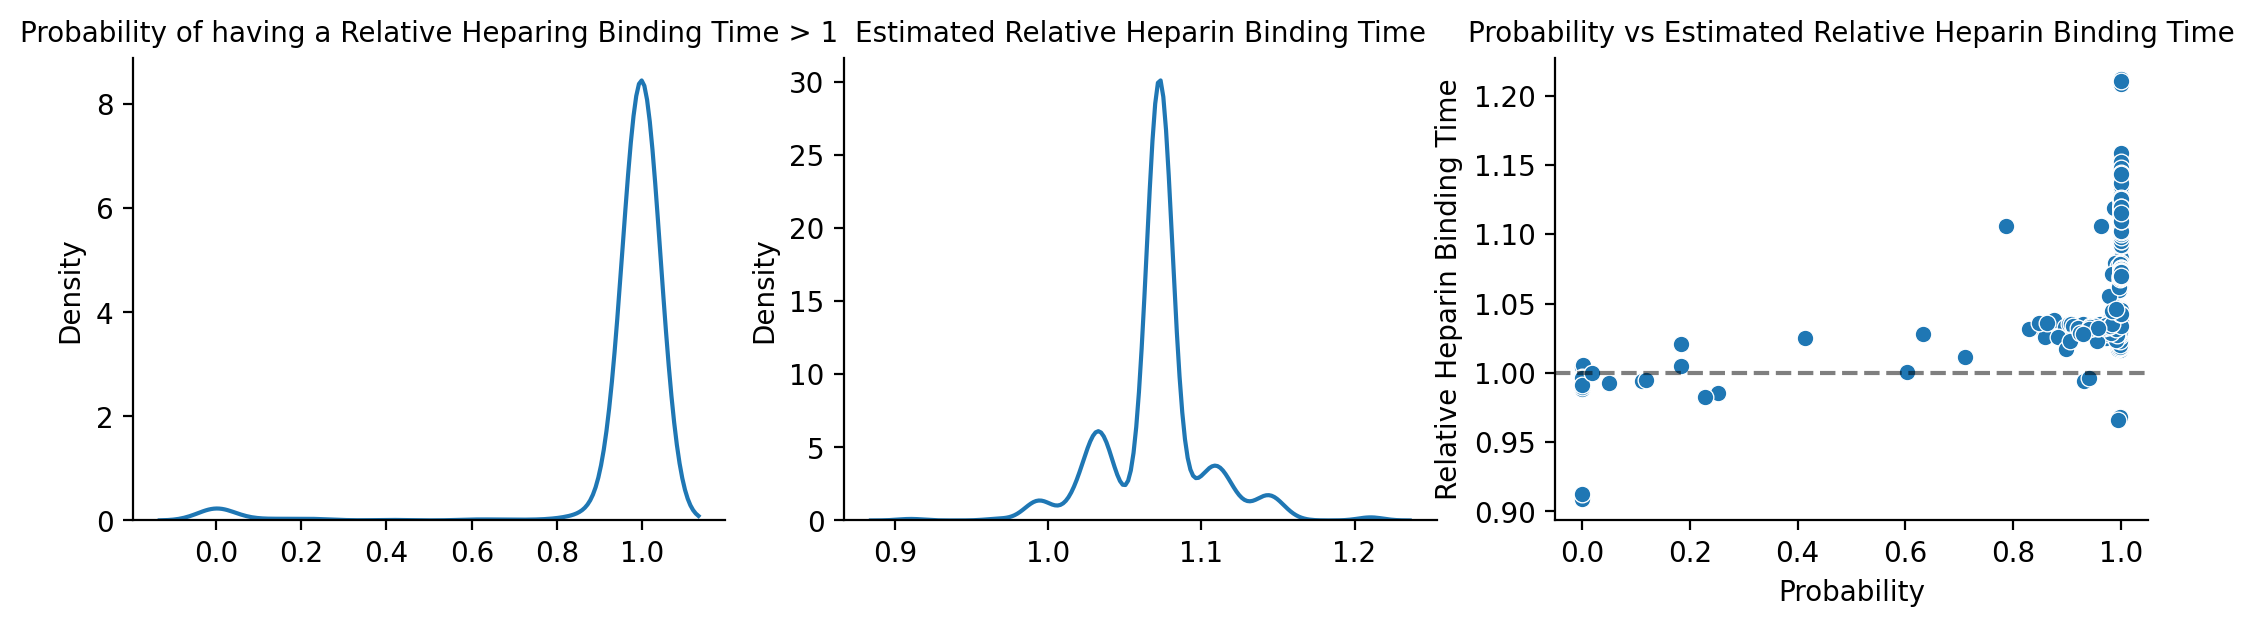

In [18]:
fig, axes = plt.subplots(1,3, figsize=(13,3))
ax = sns.kdeplot(probs, ax = axes[0])
ax.set_title('Probability of having a Relative Heparing Binding Time > 1', size = 10)
ax = sns.kdeplot(relative_heparin, ax = axes[1])
ax.set_title('Estimated Relative Heparin Binding Time', size = 10)

ax = sns.scatterplot(x=probs, y=relative_heparin, ax = axes[2])
ax.set_title('Probability vs Estimated Relative Heparin Binding Time', size = 10)
ax.set(xlabel = 'Probability', ylabel= 'Relative Heparin Binding Time')
ax.axhline(1, ls='--', color='k', alpha = 0.5)
sns.despine()

In [19]:
results = pd.concat([probs, relative_heparin], axis=1)
results.columns = ['Probability', 'Relative Heparin Binding Time']
results = np.round(results,4).sort_values([ 'Relative Heparin Binding Time','Probability'], ascending=[True, False])

In [20]:
def parse_mutation_name(name): 
    lc, hc = (name.replace('MPK190-L-', '')
            .split('-H-'))
    
    lc = lc.replace('V48L', '').replace('-', '')
    if lc: 
        lc = f'L|{lc}'
        new_name = lc
    
    for m in ['A49S','T77K', 'I101Y']:
        hc = hc.replace(m, '')
    hc = hc.replace('-', '')
    if hc: 
        hc = f'H|{hc}'
        new_name = hc
    
    return new_name
    
results['mutation'] = pd.Series(results.index).apply(parse_mutation_name).values

cols = ['mutation', 'Probability', 'Relative Heparin Binding Time']
results = results[cols]

results.to_csv(mutations_path/'mutations_results.csv', index=False)
results.to_parquet(mutations_path/'mutations_results.parquet')
               
    

In [21]:
results.head(10)

,mutation,Probability,Relative Heparin Binding Time
MPK190-L-V48L-H-R43D-A49S-T77K-I101Y,H|R43D,0.0000,0.9086
MPK190-L-V48L-H-R43E-A49S-T77K-I101Y,H|R43E,0.0000,0.9122
MPK190-L-V48L-H-A49S-K65E-T77K-I101Y,H|K65E,0.9945,0.9660
MPK190-L-V48L-H-A49S-K65D-T77K-I101Y,H|K65D,0.9977,0.9682
MPK190-L-V48L-H-A49S-T77K-R87E-I101Y,H|R87E,0.2279,0.9826
MPK190-L-V48L-H-A49S-T77K-R87D-I101Y,H|R87D,0.2525,0.9851
MPK190-L-V48L-H-R43T-A49S-T77K-I101Y,H|R43T,0.0000,0.9880
MPK190-L-V48L-H-R43H-A49S-T77K-I101Y,H|R43H,0.0000,0.9892
MPK190-L-V48L-H-P41E-A49S-T77K-I101Y,H|P41E,0.0000,0.9894
MPK190-L-V48L-H-R43V-A49S-T77K-I101Y,H|R43V,0.0000,0.9898


### Examine some of the feature activations for the classification. 
By feature activation, I mean the scaled input feature $z_i = \frac{x_i - \bar{x}}{\sigma_x}$. This is for the classifier. 

In [22]:
def calculate_activations(model, X):
    """calculate activations of linear model"""
    """ plot feature importances"""
    if hasattr(model[-1], 'feature_importances_'):
        return "Model does not have activations"
    
    if hasattr(model[-1], 'coef_'):
        weights = model[-1].coef_
        shape = weights.shape
        if len(shape)==2:
            weights = weights[0]

        title = 'Coefficients'
    
    features = model[:-1].get_feature_names_out()
    X = model[0].transform(X[features].values.reshape(1,-1))[0]
    return pd.Series(X*weights, index = features)


In [23]:
clf_activations = descriptors_df.apply(lambda x: calculate_activations(clf, x), axis=1)
clf_activations.index = pd.Series(clf_activations.index).apply(parse_mutation_name).values

[]

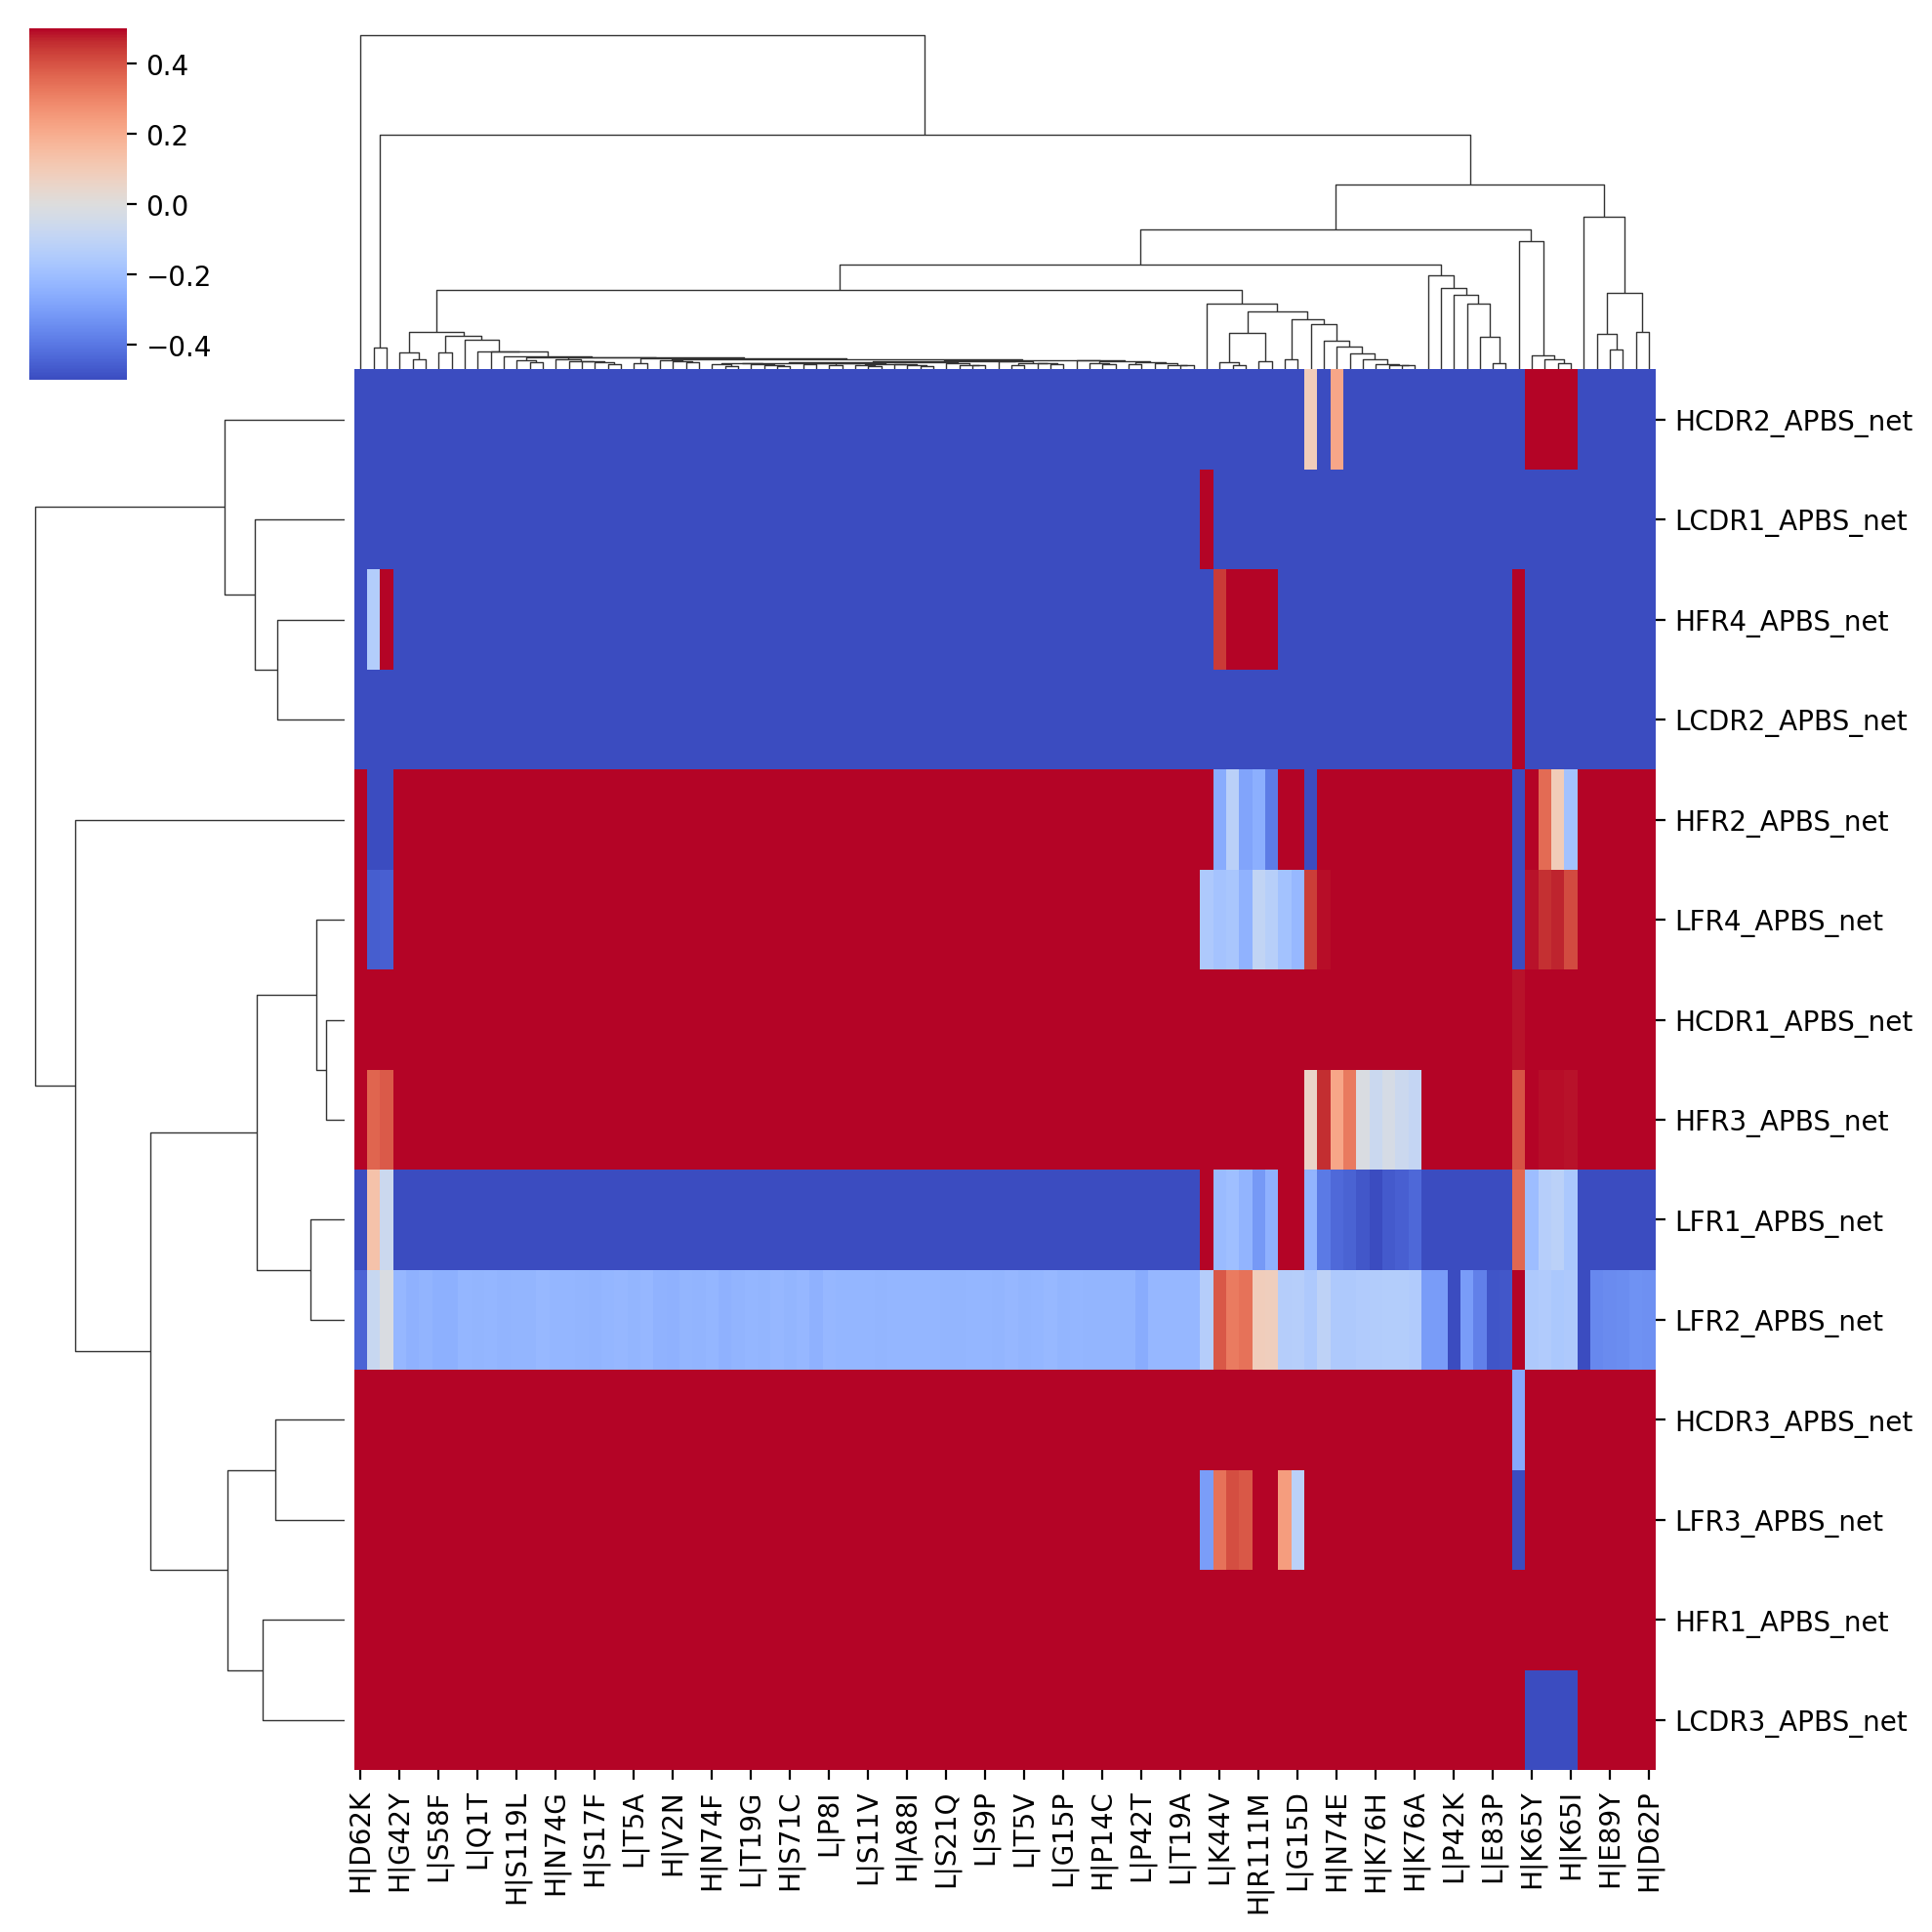

In [24]:
ax = sns.clustermap(clf_activations.sample(100, random_state =42).T, cmap='coolwarm', center=0, vmin=-0.5, vmax=0.5)
plt.gca().set_xticklabels('')



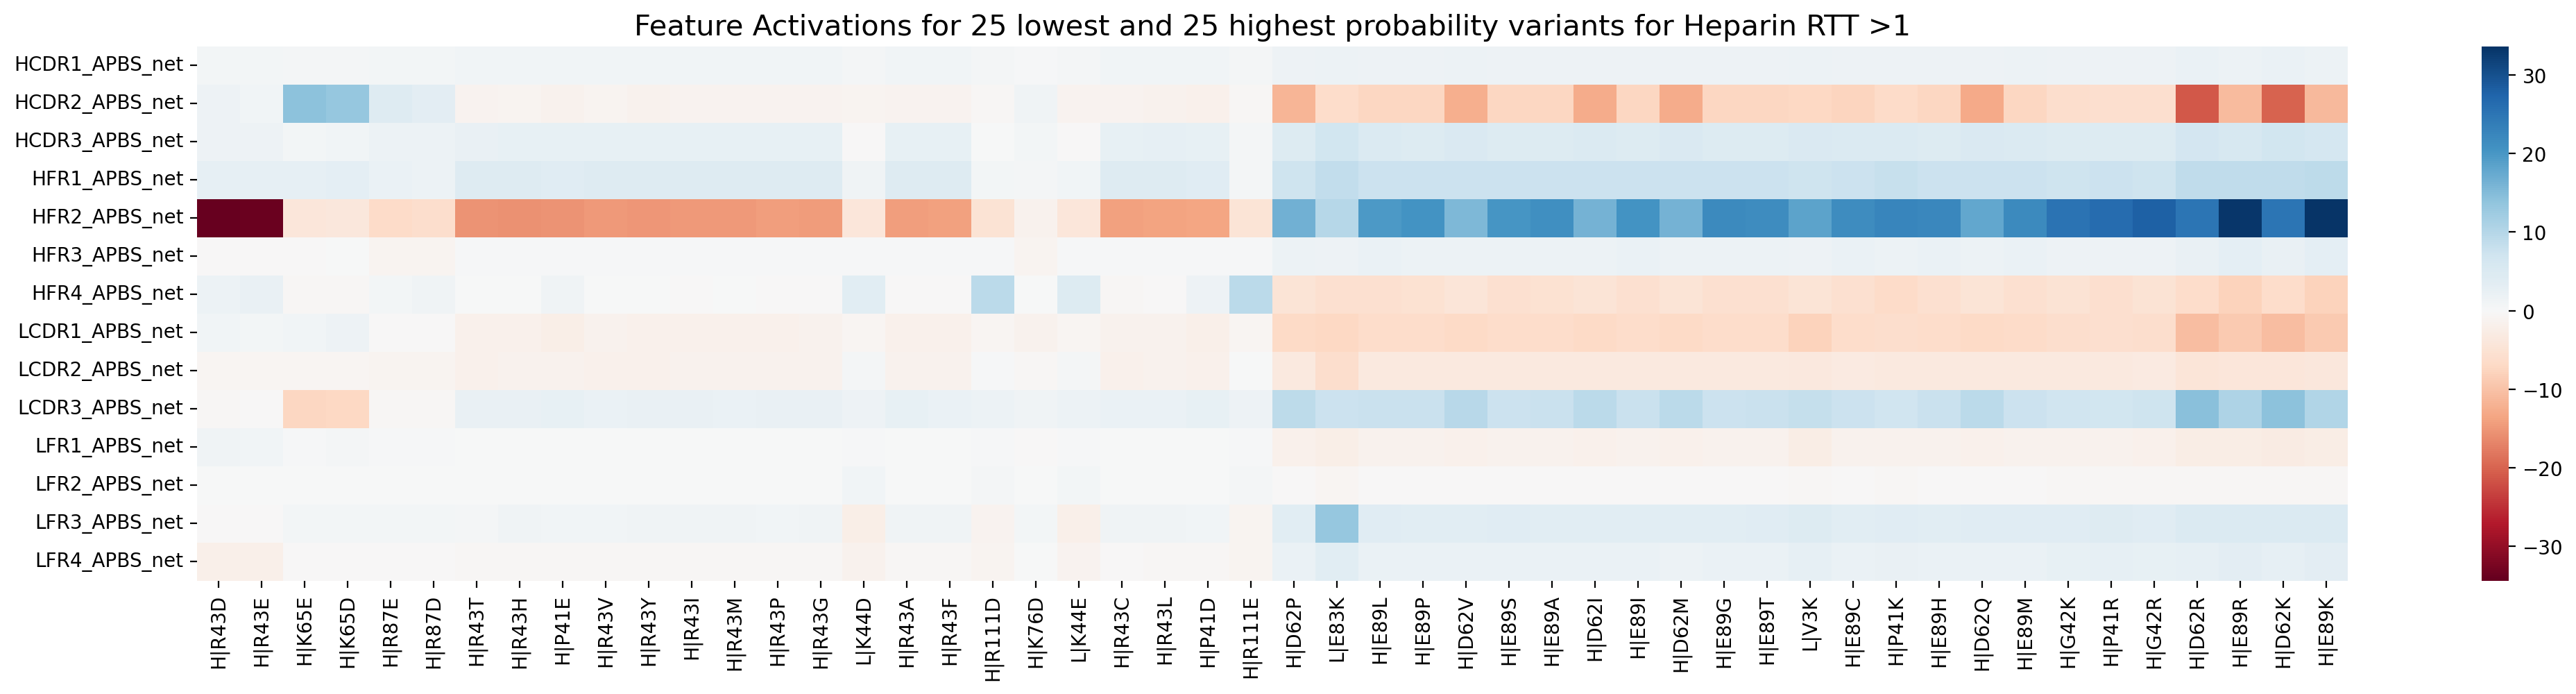

In [25]:
clf_activations = clf_activations.loc[results['mutation'].values]
plt.figure(figsize=(25,5))
ax = sns.heatmap(pd.concat([clf_activations.head(25), clf_activations.tail(25)]).T, cmap='RdBu', center=0)
ax.set_title('Feature Activations for 25 lowest and 25 highest probability variants for Heparin RTT >1', size = 15);


### Remarks: 
I shared these results with Kevin and Ishtvan, who used this to make decision on which mAbs to order. 